## Import and data split initiaion

In [2]:
import shutil
import os
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
from ultralytics import YOLO
import ultralytics
import sys
import matplotlib.pyplot as plt

### Move splitted data back to the directory images

In [3]:
def move_back_img():
    for root, dirs, files in os.walk("./IP102/dataset"):
        for file in files:
            if file.lower().endswith('.jpg'):
                src_file_path = os.path.join(root, file)
                dst_file_path = os.path.join("IP102/ip102_v1.1/images/", file)
                shutil.move(src_file_path, dst_file_path)

In [4]:
move_back_flag = True # True => put data back

In [5]:
if move_back_flag:
    move_back_img()

## Create a look-up dictionary for label number and class noun.

In [6]:
with open("IP102/ip102_v1.1/num_label.txt") as f:
    num_to_label = {}
    for text in f.read().split("\n"):
        n,l = text.split(' ',1);
        num_to_label[n] = l.strip()

## Create empty classification directory to fit the YOLO dataset format

In [7]:
create_flag = False # True => create now

if create_flag == True:
    for s in split_type:
        for label in num_to_label.values():
            train_class_dir = 'IP102/dataset/train/' + label
            val_class_dir = 'IP102/dataset/val/' + label
            test_class_dir = 'IP102/dataset/test/' + label
            os.mkdir(train_class_dir)
            os.mkdir(val_class_dir)
            os.mkdir(val_class_dir)

### make a table for converting from image to label number

In [187]:
"""
"IP102/ip102_v1.1/name_num_table.txt" has image name and label number
image name   (e.g.  xxxxx.jpg)
class number (e.g.          1)

name_to_num[:,0] => image names
name_to_num[:,1] => label numbers
"""

with open("IP102/ip102_v1.1/name_num_table.txt") as f:
    name_to_num = [] # class data
    for l in f.read().split("\n"):
        v = tuple(l.split())
        if v:
            v = [v[0],str(int(v[1])+1)] # to fit the format in num_to_label.txt
            name_to_num.append(v)

name_to_num = np.array(name_to_num)
label_list = list(set(name_to_num[:,1]))

### Move image to train/val/test

In [188]:
def move_img(train_val_test_pack):
    src_directory = "IP102/ip102_v1.1/images/"
    for split_type, name_num_dic in train_val_test_pack.items():
        for name, num in zip(name_num_dic["name"], name_num_dic["num"]):
            dst_directory = "IP102/dataset/{:s}/{:s}".format(split_type, num_to_label[num])
            shutil.move(src_directory + name, dst_directory)

## 5-fold cross validation by StratifiedKFold 

In [204]:
quick_demo_flag = True
methods = ['down_sampling', 'stratified']
method_selection = 'down_sampling'
down_sampling_size = 2 # size for each train, val, and test set in each fold 
stratified_size = 1/10 # reduced ratio

In [205]:
k = 2 # number of folds

In [206]:
from collections import defaultdict
import random
print("data size")
print("Whole: ", len(name_to_num))
if quick_demo_flag == True:
    if method_selection == 'down_sampling':
        # Downsampling method
        grouped = defaultdict(list)
        for name, num in zip(name_to_num[:,0],name_to_num[:,1]):
            grouped[num].append(name)
    
        min_size = min(len(names) for names in grouped.values())
        accept_min = np.floor(min_size/(3*k)) # 
    
        if (down_sampling_size > accept_min):
            print("down_sampling_size is bigger than accpetable size. Some classes cannot be distributed to train/val/test sets.")
            down_sampling_size = accept_min
            print("down_sampling_size is set to the minimun: ".format(down_sampling_size))
            
        random.seed(42)
        
        reduced_dataset_name = []
        reduced_dataset_num = []
        for num, names in grouped.items():
            reduced_dataset_name.extend(random.sample(names,down_sampling_size*3*k))
            reduced_dataset_num.extend([num]*down_sampling_size*3*k)
    
        final_name_to_num = np.array(list(zip(reduced_dataset_name,reduced_dataset_num)))

    elif method_selection == 'stratified':
        _, name_reduced_data, _, num_reduced_data = train_test_split(name_to_num[:,0], 
                                                                    name_to_num[:,1], 
                                                                    stratify=name_to_num[:,1],
                                                                    test_size=stratified_size,
                                                                    random_state=43)
        final_name_to_num = np.array(list(zip(name_reduced_data,num_reduced_data)))

    print("Reduced : ", len(final_name_to_num))
  
else:
    final_name_to_num = name_to_num.copy()

data size
Whole:  75222
Reduced :  1505


In [207]:
# train-val-test : 6-2-2
move_back_img()
skf = StratifiedKFold(n_splits=k)
temp_counter = 0;

for train_index, test_index in skf.split(final_name_to_num[:,0], final_name_to_num[:,1].astype(int)):
    if temp_counter != 0:
        break;
    temp_counter+=1
    
    test_dataset = np.array([final_name_to_num[i] for i in test_index])
    name_test, num_test = test_dataset[:,0], test_dataset[:,1]
    
    train_dataset = np.array([final_name_to_num[i] for i in train_index])
    name_train, name_val, num_train, num_val = train_test_split(train_dataset[:,0], 
                                                                    train_dataset[:,1], 
                                                                    stratify=train_dataset[:,1],
                                                                    test_size=0.25,
                                                                    random_state=43)
    train_val_test_pack = {
        "train": {"name":name_train,"num":num_train},
        "val":{"name":name_val,"num":num_val},
        "test":{"name":name_test,"num":num_test}
    }

    move_img(train_val_test_pack)

ValueError: The least populated class in y has only 1 member, which is too few. The minimum number of groups for any class cannot be less than 2.

### plot classification imbalance

Number of Classes for Whole Data Data: 102
Number of Classes for Train Data: 102
Number of Classes for Val Data: 102
Number of Classes for Test Data: 99


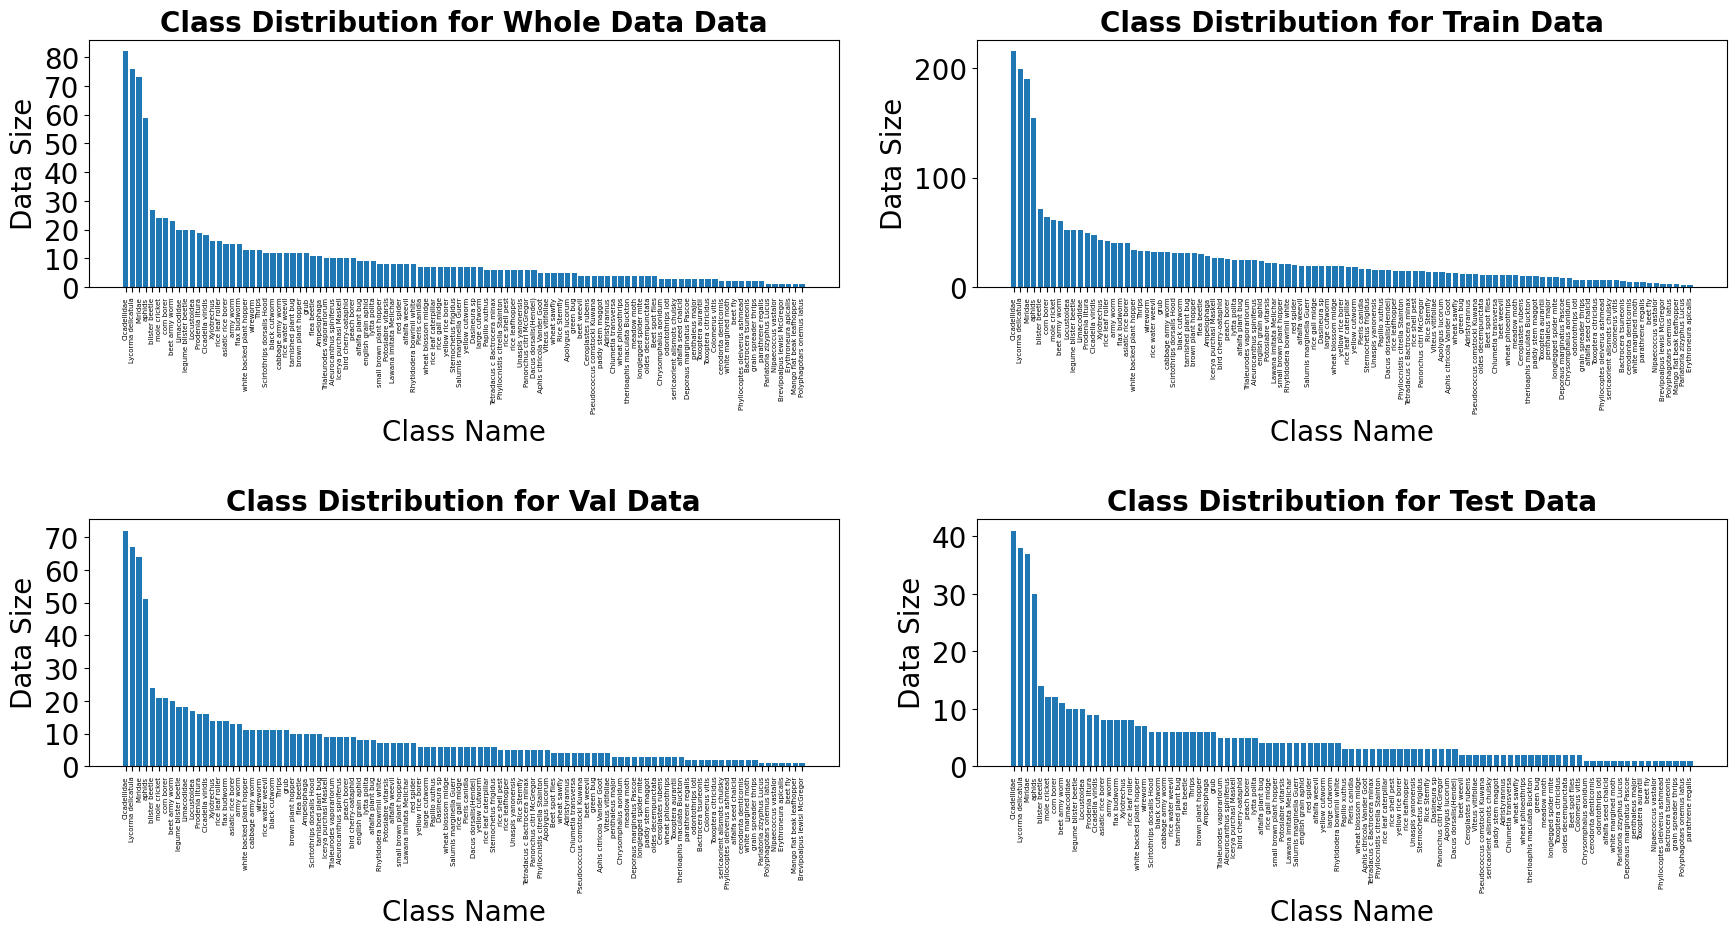

In [202]:
# Plot for whole data
from collections import Counter
import matplotlib.ticker as ticker
import warnings
warnings.simplefilter('ignore')

num_list = {
    "Whole Data":final_name_to_num[:,1],
    "Train":num_train,
    "Val":num_val,
    "Test":num_test
}

l = len(num_list)
fig, ax= plt.subplots(2,2, figsize=(18, 10))


for i, (set_type, num) in enumerate(num_list.items()):
    dataset_count = Counter([num_to_label[single_num] for single_num in num])
    dataset_count = sorted(dataset_count.items(), key=lambda item: item[1],reverse=True)
    class_names, count_values = zip(*dataset_count)

    x = np.floor(i/2).astype(int)
    y = i%2

    b_text = 20
    m_text = 20
    s_text = 5
    
    ax[x][y].bar(class_names, count_values)
    ax[x][y].set_title('Class Distribution for {:s} Data'.format(set_type), fontsize=b_text, fontweight='bold')
    ax[x][y].set_xlabel('Class Name', fontsize=m_text)
    ax[x][y].set_ylabel('Data Size', fontsize=m_text)
    ax[x][y].xaxis.set_tick_params(rotation=90)


    max_count = max(count_values)

    n = int(np.floor(np.log10(max_count)))
    step = 10**n

    ax[x][y].yaxis.set_major_locator(ticker.MultipleLocator(step))
    ax[x][y].set_xticklabels(ax[x][y].get_xticklabels(), fontsize=s_text)
    ax[x][y].set_yticklabels(ax[x][y].get_yticklabels(), fontsize=m_text)

    # y_ticks = list(ax[x][y].get_yticks())
    # max_count_float = float(max_count)
    
    # if not any(np.isclose(tick, max_count_float) for tick in y_ticks):
    #     y_ticks.append(max_count_float)
    #     y_ticks = sorted(y_ticks)
        

    # if max_count not in y_ticks:
    #     y_ticks.append(max_count)
    #     y_ticks = sorted(y_ticks)
    
    # ax[x][y].set_yticks(y_ticks)
    # ax[x][y].set_ylim(bottom =0)

    # labels = [str(int(tick)) if tick.is_integer() else f"{tick:.1f}" for tick in y_ticks]
    # ax[x][y].set_yticklabels(labels, fontsize=m_text)
    

    print("Number of Classes for {} Data: {}".format(set_type, len(class_names) ))

fig.tight_layout(pad=3.0)
fig.show()

#plt_dist_balance(name_train)

## YOLO training

In [171]:
ultralytics.__version__

# '8.3.134'

'8.3.134'

In [172]:
print(os.getcwd())

/Users/ikutatouma/Desktop/PBL5/project


In [ ]:
# Load a pretrained YOLO11n model
model = YOLO("yolov8n-cls.pt")

train_results = model.train(
    data= os.getcwd() + "/IP102/dataset",
    epochs=1,
    imgsz=640,
    device="cpu")

metrics = model.val()

results = model()
results[0].show()


# Path to test dataset
test_dir = os.getcwd() + "IP102/dataset/test"  # adjust if needed

y_true = []
y_pred = []

# Map class names to index (must match order in your YAML 'names')
class_names = model.names
class_to_idx = {name: i for i, name in class_names.items()}

# Loop through test set
for class_name in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_name)
    if not os.path.isdir(class_path):
        continue
    true_idx = class_to_idx[class_name]

    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        results = model.predict(image_path, verbose=False)
        pred_idx = results[0].probs.top1
        y_true.append(true_idx)
        y_pred.append(pred_idx)

# Compute metrics
acc = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support()

# Print results
print(f"\nEvaluation on Test Set:")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

path = model.export(format="onnx")  # Returns the path to the exported model